<a href="https://colab.research.google.com/github/jiananwu72/Defect-Detection/blob/main/pyTEMlibDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyNSID sidpy SciFiReaders nanonispy gwyfile pyTEMlib wget ipympl importlib wget
!pip install numpy==1.26.4

In [2]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.3.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')


done


In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../../../sidpy')
import sidpy

%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools      # File input/ output library
import pyTEMlib.image_tools

print('pyTEMlib version: ', pyTEMlib.__version__)
note_book_version = '2025.05.19'
note_book_name='pyTEMib/notebooks/Imaging/Adaptive_Fourier_Filter'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 
pyTEMlib version:  0.2025.03.0


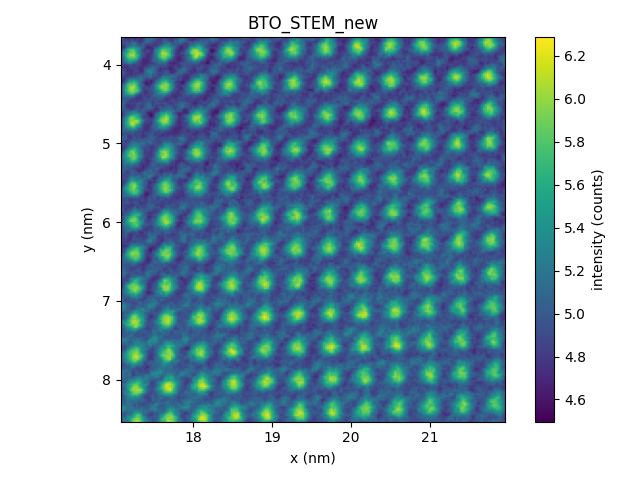

In [4]:
import wget
import SciFiReaders as sr
wget.download(url='https://zenodo.org/record/8190744/files/bto_atomic.dm3?download=1',
              out = 'bto_atomic.dm3')

dm3_file = r'bto_atomic.dm3'
dm3_reader = sr.DM3Reader(dm3_file)
dataset = dm3_reader.read()["Channel_000"]
dataset.title = 'BTO_STEM'
dataset._axes[0].quantity = 'x'
dataset._axes[1].quantity = 'y'
dataset = dataset[700:900,150:350]
dataset.plot();

##Fourier Filtering

In [5]:
print(dataset.provenance)
im = dataset.sum(axis=0)
im.provenance

{'sidpy': {'like_data': '_0.12.7_2025-05-12-18:43:22.073310', 'parent_data': {'title': 'BTO_STEM', 'provenance': {'sidpy': {'from_array_': '_0.12.7_2025-05-12-18:43:22.067086'}}}}}


{'sidpy': {'like_data': '_0.12.7_2025-05-12-18:43:23.165472',
  'parent_data': {'title': 'BTO_STEM_new',
   'provenance': {'sidpy': {'like_data': '_0.12.7_2025-05-12-18:43:22.073310',
     'parent_data': {'title': 'BTO_STEM',
      'provenance': {'sidpy': {'from_array_': '_0.12.7_2025-05-12-18:43:22.067086'}}}}}}}}

fft :
	smoothing : 1
	minimum_intensity : 2.172076344571273
	maximum_intensity : 7.3917250670772185
source:  BTO_STEM_new


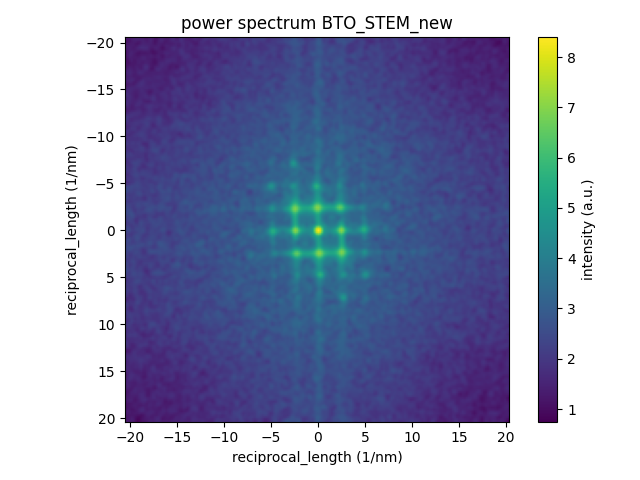

In [6]:
if dataset.data_type.name == 'IMAGE_STACK':
  stack_dim = dataset.get_dimensions_by_type('TEMPORAL')
  image = dataset.sum(axis=stack_dim)
  image.data_type = 'Image'
elif dataset.data_type.name == 'IMAGE':
  image = dataset
else:
  print('We really would need an image here')

power_spectrum = pyTEMlib.image_tools.power_spectrum(image, smoothing=1)
power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = power_spectrum.plot()

Found 17 reflections


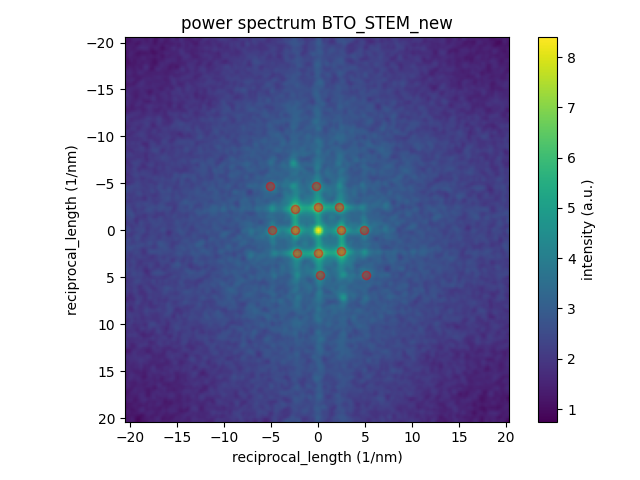

In [7]:
# ------Input----------
spot_threshold=0.09
# ---------------------

spots, _ = pyTEMlib.image_tools.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<7,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

In [8]:
dataset.provenance

{'sidpy': {'like_data': '_0.12.7_2025-05-12-18:43:22.073310',
  'parent_data': {'title': 'BTO_STEM',
   'provenance': {'sidpy': {'from_array_': '_0.12.7_2025-05-12-18:43:22.067086'}}}}}

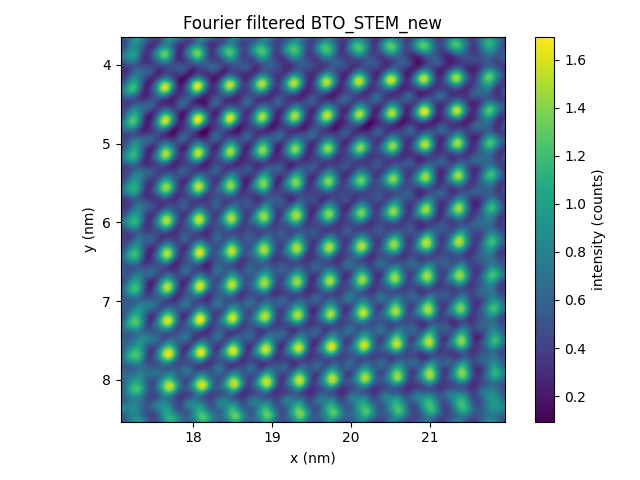

In [9]:
filtered_dataset = pyTEMlib.image_tools.adaptive_fourier_filter(image, spots,
                                                                low_pass=2.0, reflection_radius=.5)
view = filtered_dataset.plot()

fft :
	smoothing : 1
	minimum_intensity : 2.172076344571273
	maximum_intensity : 7.3917250670772185
source:  BTO_STEM_new


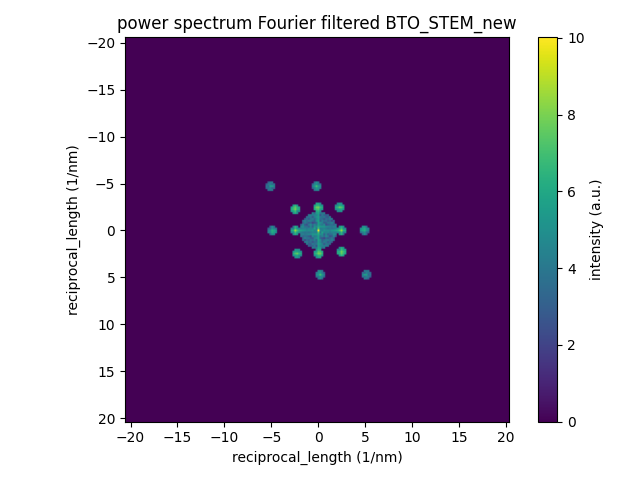

In [10]:
filtered_power_spectrum = pyTEMlib.image_tools.power_spectrum(filtered_dataset, smoothing=0)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
view = filtered_power_spectrum.plot()

In [11]:
print(spots[:5])

[[ 0.         -2.4576      3.14159265]
 [ 0.          2.4576      0.        ]
 [-2.4576      0.         -1.57079633]
 [ 2.4576      0.          1.57079633]
 [-2.2528      2.4576     -0.74194727]]


LR Deconvolution

0.8192
smal
3 0.0732421875
Deconvolution of  BTO_STEM_new


  0%|          | 0/500 [00:00<?, ?it/s]

converged in 63 iterations

 Lucy-Richardson deconvolution converged in 63  iterations


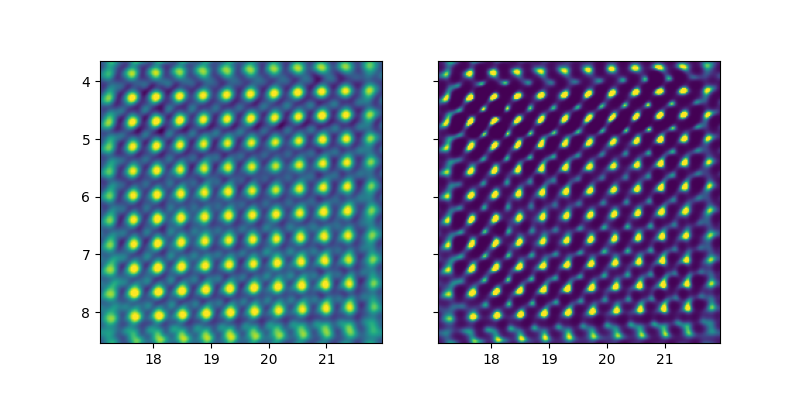

In [12]:
import pyTEMlib.probe_tools

# ------- Input ------
atoms_size = .02 # in nm
# --------------------
# image = dataset.sum(axis=0)
image = filtered_dataset

out_tags = {}
image.metadata['experiment']= {'convergence_angle': 30, 'acceleration_voltage': 200000.}

scale_x =image.x.slope
gauss_diameter = atoms_size/scale_x
print(gauss_diameter)
if gauss_diameter < 3:
    print('smal')
    gauss_diameter = 3
print(gauss_diameter, gauss_diameter*scale_x)
gauss_probe = pyTEMlib.probe_tools.make_gauss(image.shape[0], image.shape[1], gauss_diameter)

print('Deconvolution of ', dataset.title)
LR_dataset = pyTEMlib.image_tools.decon_lr(image, gauss_probe, verbose=False)

extent = LR_dataset.get_extent([0,1])
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T, extent = extent,vmax=np.median(np.array(image))+3*np.std(np.array(image)))
ax[1].imshow(LR_dataset.T, extent = extent, vmax=np.median(np.array(LR_dataset))+3*np.std(np.array(LR_dataset)));

In [13]:
LR_dataset.metadata.update({'analysis': {'Lucy_Richardson': {
                        'notebook': 'Image_Registration' ,
                        # 'notebook_version': __notebook_version__,
                        'input': dataset.title,
                        'probe_diameter': gauss_diameter,
                        'kind_of_probe': 'Gauss',
                        'probe_width': atoms_size
                        }}})
LR_dataset.metadata

{'analysis': {'Lucy_Richardson': {'notebook': 'Image_Registration',
   'input': 'BTO_STEM_new',
   'probe_diameter': 3,
   'kind_of_probe': 'Gauss',
   'probe_width': 0.02}},
 'spots': array([[ 0.        , -2.4576    ,  3.14159265],
        [ 0.        ,  2.4576    ,  0.        ],
        [-2.4576    ,  0.        , -1.57079633],
        [ 2.4576    ,  0.        ,  1.57079633],
        [-2.2528    ,  2.4576    , -0.74194727],
        [ 2.2528    , -2.4576    ,  2.39964539],
        [-2.4576    , -2.2528    , -2.31274359],
        [ 2.4576    ,  2.2528    ,  0.82884906],
        [-0.2048    , -4.7104    , -3.09814176],
        [ 0.2048    ,  4.7104    ,  0.0434509 ],
        [-4.9152    ,  0.        , -1.57079633],
        [ 4.9152    ,  0.        ,  1.57079633],
        [-5.12      , -4.7104    , -2.31455191],
        [ 5.12      ,  4.7104    ,  0.82704074]]),
 'low_pass': 2.0,
 'reflection_radius': 0.5,
 'experiment': {'convergence_angle': 30,
  'acceleration_voltage': 200000.0,
  'wav

##Atom Finding

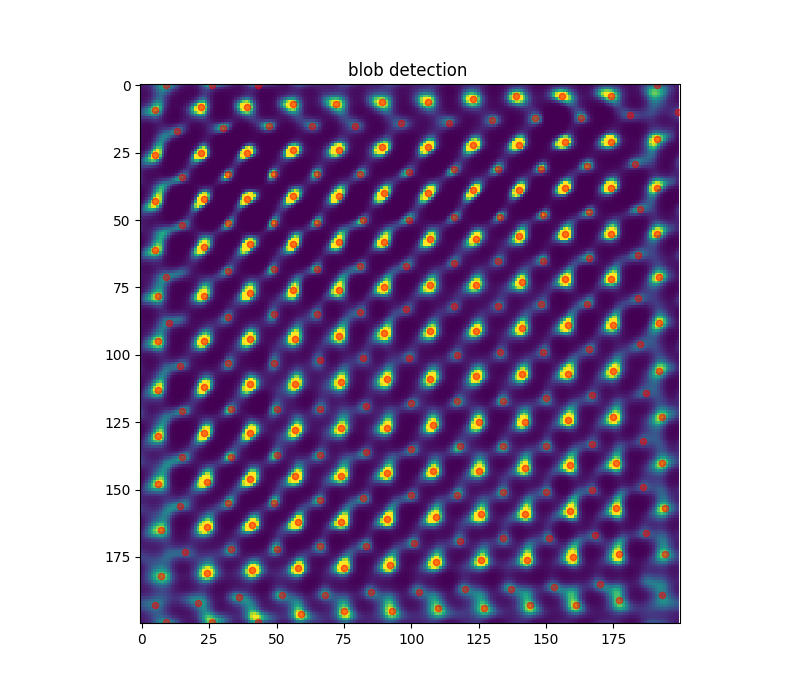

In [26]:
import skimage
# ------- Input ------
threshold = 0.1 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = .22 #in nm
min_atom_size = .06 #in nm
# ----------------------

image = LR_dataset
#image = image_choice.dataset
# scale_x = pyTEMlib.file_tools.get_slope(image.dim_1)
blobs =  skimage.feature.blob_log(image, min_sigma = min_atom_size/scale_x, max_sigma=atom_size/scale_x, threshold=threshold)

fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

In [27]:
out_tags  =  {}
out_tags['analysis']= 'Atom Positions'
# out_tags['notebook']= __notebook__
# out_tags['notebook_version']= __notebook_version__

out_tags['atoms'] = blobs
out_tags['atom_size'] = atom_size #in nm gives the size of the atoms or resolution
out_tags['threshold'] =  threshold  #between 0.01 and 0.1
out_tags['pixel_size'] = scale_x


out_tags['name'] = 'Atom finding'
out_tags['title'] = out_tags['name']
tags = {'atom_pixel':  out_tags}
if isinstance(image.metadata['analysis'], str):
    image.metadata['analysis']={image.metadata['analysis']:{}}

image.metadata['analysis'].update(tags)

image.metadata['analysis']

{'Lucy_Richardson': {'notebook': 'Image_Registration',
  'input': 'BTO_STEM_new',
  'probe_diameter': 3,
  'kind_of_probe': 'Gauss',
  'probe_width': 0.02},
 'atom_pixel': {'analysis': 'Atom Positions',
  'atoms': array([[ 39.       ,  25.       ,   2.4576   ],
         [ 39.       ,  42.       ,   2.4576   ],
         [157.       ,  38.       ,   2.4576   ],
         [157.       ,  21.       ,   2.4576   ],
         [ 22.       ,  25.       ,   2.4576   ],
         [ 56.       ,  24.       ,   2.4576   ],
         [ 56.       ,  41.       ,   2.4576   ],
         [ 23.       ,  42.       ,   2.4576   ],
         [140.       ,  39.       ,   2.4576   ],
         [140.       ,  22.       ,   2.4576   ],
         [ 41.       , 163.       ,   2.4576   ],
         [174.       ,  38.       ,   2.4576   ],
         [ 40.       ,  59.       ,   2.4576   ],
         [106.       ,  23.       ,   2.4576   ],
         [123.       ,  22.       ,   2.4576   ],
         [157.       ,  55.       ,   

sidpy.Dataset of type IMAGE with:
 dask.array<sub, shape=(200, 200), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  x (nm) of size (200,)
y:  y (nm) of size (200,)
 with metadata: ['analysis', 'spots', 'low_pass', 'reflection_radius', 'experiment']
using radius  3 pixels


  0%|          | 0/269 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pyTEMlib/probe_tools.py:17: RuntimeWarning: invalid value encountered in divide
  probe = g / g.sum() * intensity


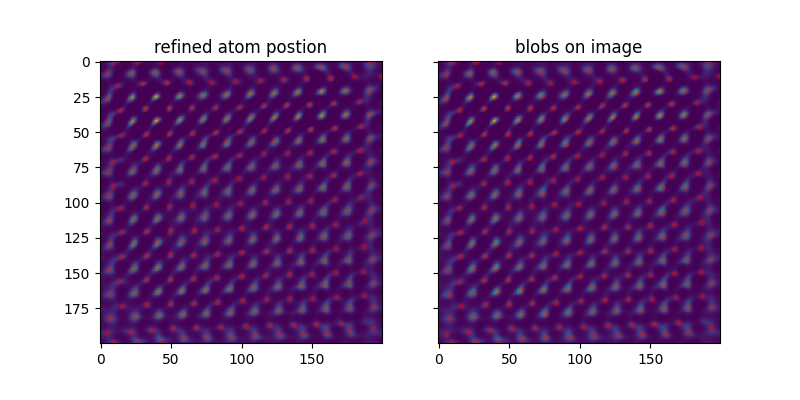

In [28]:
import pyTEMlib.atom_tools
atom_radius = 3
#atoms = atom_group['atoms'][()]
atoms = blobs
image = image-image.min()
print(image)

#atom_radius = 2
MaxInt = 0
MinInt = 0
maxDist = 2
sym = pyTEMlib.atom_tools.atom_refine(np.array(image), atoms, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,0],refined_atoms[:,1],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

In [29]:
out_tags  =  {}
out_tags['analysis']= 'Atom Positions'
# out_tags['notebook']= __notebook__
# out_tags['notebook_version']= __notebook_version__

out_tags['atoms'] = blobs
out_tags['atom_size'] = atom_size #in nm gives the size of the atoms or resolution
out_tags['threshold'] =  threshold  #between 0.01 and 0.1
out_tags['pixel_size'] = scale_x


out_tags['name'] = 'Atom finding'
out_tags['title'] = out_tags['name']
tags = {'atom_pixel':  out_tags}
if isinstance(image.metadata['analysis'], str):
    image.metadata['analysis']={image.metadata['analysis']:{}}

image.metadata['analysis'].update(tags)

image.metadata['analysis']

{'Lucy_Richardson': {'notebook': 'Image_Registration',
  'input': 'BTO_STEM_new',
  'probe_diameter': 3,
  'kind_of_probe': 'Gauss',
  'probe_width': 0.02},
 'atom_pixel': {'analysis': 'Atom Positions',
  'atoms': array([[ 39.       ,  25.       ,   2.4576   ],
         [ 39.       ,  42.       ,   2.4576   ],
         [157.       ,  38.       ,   2.4576   ],
         [157.       ,  21.       ,   2.4576   ],
         [ 22.       ,  25.       ,   2.4576   ],
         [ 56.       ,  24.       ,   2.4576   ],
         [ 56.       ,  41.       ,   2.4576   ],
         [ 23.       ,  42.       ,   2.4576   ],
         [140.       ,  39.       ,   2.4576   ],
         [140.       ,  22.       ,   2.4576   ],
         [ 41.       , 163.       ,   2.4576   ],
         [174.       ,  38.       ,   2.4576   ],
         [ 40.       ,  59.       ,   2.4576   ],
         [106.       ,  23.       ,   2.4576   ],
         [123.       ,  22.       ,   2.4576   ],
         [157.       ,  55.       ,   

##Position Analyzing

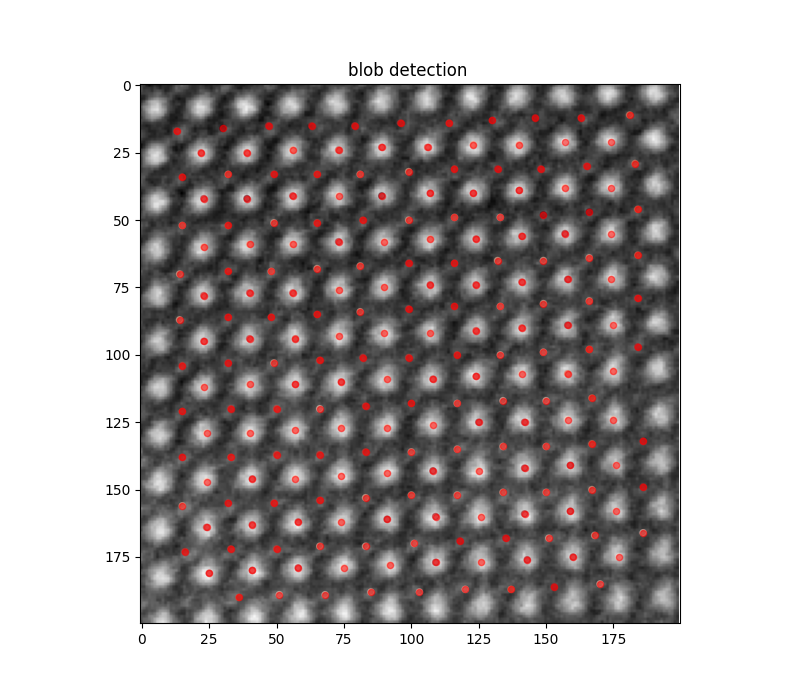

In [18]:
import scipy
import pyTEMlib.graph_tools
def breath_first(graph, initial, lattice_parameter, tolerance=1):

    neighbour_tree = scipy.spatial.KDTree(graph)
    distances, indices = neighbour_tree.query(graph,  # let's get all neighbours
                                              k=50)  # projection_tags['number_of_nearest_neighbours']*2 + 1)
    visited = []  # the atoms we visited
    angles = []  # atoms at ideal lattice
    sub_lattice = []
    sub_lattice = []  # atoms in base and disregarded
    queue = [initial]
    queue_angles=[0]

    while queue:
        node = queue.pop(0)
        angle = queue_angles.pop(0)

        if node not in visited and node not in sub_lattice:
            visited.append(node)
            angles.append(angle)
            neighbors = indices[node]
            for i, neighbour in enumerate(neighbors):
                if neighbour not in visited:
                    hopp = graph[node] - graph[neighbour]
                    distance_to_ideal = np.linalg.norm(hopp)
                    if distance_to_ideal < lattice_parameter - tolerance*5:
                        sub_lattice.append(neighbour)
                    elif np.min(np.abs(distance_to_ideal- lattice_parameter)) < tolerance:
                        queue.append(neighbour)
                        queue_angles.append(np.arctan2(hopp[1], hopp[0]))
    angles[0] = angles[1]
    out_atoms = np.stack([graph[visited][:, 0], graph[visited][:, 1], angles])
    return out_atoms.T, visited

def delete_rim_atoms(atoms, extent, rim_distance):
    rim = np.where(atoms[:, :2] - extent > -rim_distance)[0]
    middle_atoms = np.delete(atoms, rim, axis=0)
    rim = np.where(middle_atoms[:, :2].min(axis=1)<rim_distance)[0]
    middle_atoms = np.delete(middle_atoms, rim, axis=0)
    return middle_atoms
init = 200
#init = 6328
#init= 6589

hopped_atoms, indices = breath_first(blobs, init, 22, 5)
middle_atoms = pyTEMlib.graph_tools.delete_rim_atoms(hopped_atoms, image.shape, 10)

plt.close('all')
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

# plt.imshow(dataset.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.imshow(dataset.T,cmap='gray')
plt.scatter(middle_atoms[:, 0], middle_atoms[:, 1], c=np.degrees(np.degrees(middle_atoms[:, 2])% 60), cmap = 'Reds', s=20, alpha = .5);
plt.scatter(middle_atoms[:, 0], middle_atoms[:, 1], c='red', s=20, alpha = .5);
#plt.scatter(blobs[init][0], blobs[init][1], c='orange')
angles = np.degrees(middle_atoms[:, 2])% 60

In [19]:
crystal_name = 'SrTiO3'
crystal = pyTEMlib.crystal_tools.structure_by_name(crystal_name)
print(crystal_name)
crystal

crystal.cell.lengths()[0]/image.x.slope/10
crystal.info = {'experimental': {'zone_axis': [1, 1, 1], 'angle': 0}}
layer = pyTEMlib.crystal_tools.get_projection(crystal)
gamma =  layer.cell.angles()[2]

SrTiO3
projected atomic numbers


272
 Average unit cell angle 28.4 with standard deviation 14.42; from 0.0 to 56.8


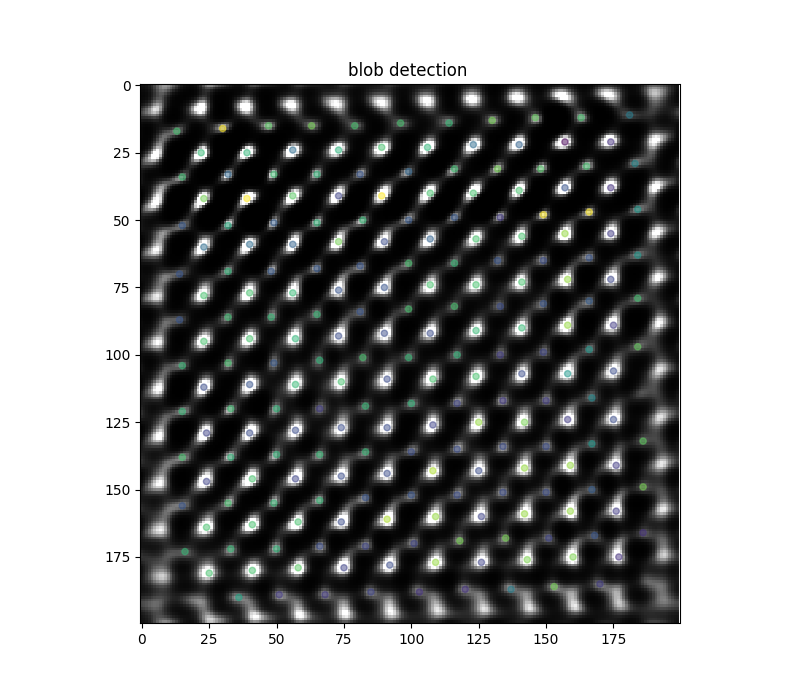

In [20]:
print(len(blobs))
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(middle_atoms[:, 0], middle_atoms[:, 1], c=np.degrees(np.degrees(middle_atoms[:, 2])% gamma), cmap = 'viridis', s=20, alpha = .5);
angles = np.degrees(middle_atoms[:, 2])% gamma

print(f' Average unit cell angle {np.average(angles):.1f} with standard deviation {np.std(angles):.2f}; from {np.min(angles):.1f} to {np.max(angles):.1f}')

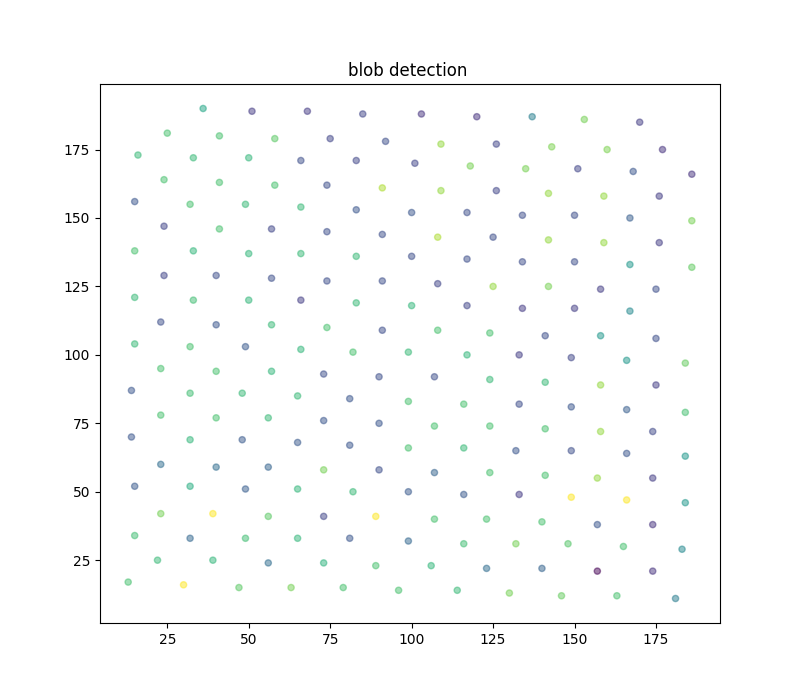

In [21]:
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")
plt.scatter(middle_atoms[:, 0], middle_atoms[:, 1], c=np.degrees(np.degrees(middle_atoms[:, 2])% gamma), cmap = 'viridis', s=20, alpha = .5);

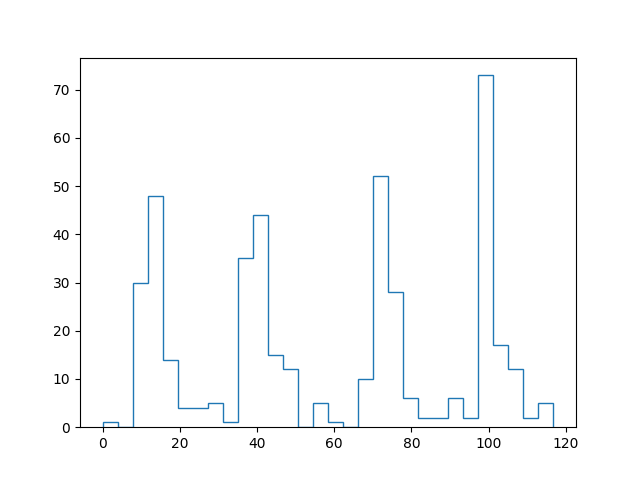

In [22]:
plt.figure()
plot_angles = np.append(angles, angles+gamma)
plot_angles[plot_angles<0] +=gamma
counts, bins = np.histogram(plot_angles, bins = 30)
plt.stairs(counts, bins)

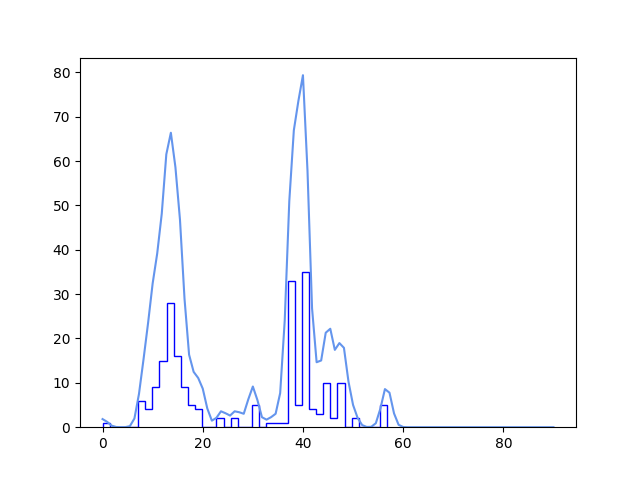

In [23]:
from sklearn.neighbors import KernelDensity
a = angles.reshape(-1,1)

kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)

kde.score_samples(a)

X_plot = np.linspace(0, 90, 100)[:, np.newaxis]

fig, ax = plt.subplots()


# Calculating the density using the gaussian kernel with bandwidth 0.5
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(a)

# Calculating the log of the probability density function
log_dens = kde.score_samples(X_plot)

# Plotting the density curve
ax.plot(
    X_plot[:, 0],
    np.exp(log_dens)*1000,
    color="cornflowerblue",
    linestyle="-",
    label="Gaussian kernel density"
)
counts, bins = np.histogram(angles, bins = 40)
ax.stairs(counts, bins, color='blue')


254


0.701642

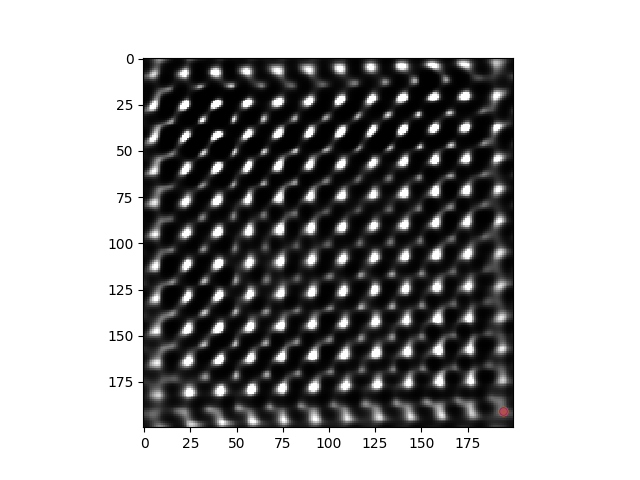

In [24]:
one_grain_indices = np.where(angles > 30)
one_grain = middle_atoms[one_grain_indices]
one_grain_angle = np.median(one_grain[:, 2]%np.radians(60))

two_grain_indices = np.where(angles < 30)
two_grain = middle_atoms[two_grain_indices]
two_grain_angle = np.median(two_grain[:, 2]%np.radians(60))

gamma = np.radians(layer.cell.angles()[2])

one_grain[100]
plt.figure()
plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
#plt.scatter(one_grain[:, 0], one_grain[:, 1], c='blue', alpha = 0.2)

init = np.argmin(np.linalg.norm(blobs[:,:2]- [674, 594], axis=1))
#init = np.argmin(np.linalg.norm(blobs[:,:2]- [610, 552], axis=1))

plt.scatter(blobs[init][0], blobs[init][1], c='orange')
projection_tags = {'lattice_vector': {'a': np.array([np.cos(one_grain_angle)*21, np.sin(one_grain_angle)*21]),
                                      'b': np.array([np.cos(one_grain_angle+gamma)*21, np.sin(one_grain_angle+gamma)*21]) },
                   'allowed_variation': 1.5,
                   'distance_unit_cell':  21*1.04}
layer.info['projection'] = projection_tags
hop1, ideal = pyTEMlib.graph_tools.breadth_first_search2(blobs[:,:2], init, layer)
projection_tags = {'lattice_vector': {'a': np.array([np.cos(two_grain_angle)*21, np.sin(two_grain_angle)*21]),
                                      'b': np.array([np.cos(two_grain_angle+gamma)*21, np.sin(two_grain_angle+gamma)*21]) },
                   'allowed_variation': 1.5,
                   'distance_unit_cell':  21*1.04}
layer.info['projection'] = projection_tags
#init = np.argmin(np.linalg.norm(blobs[:,:2]- [574, 520], axis=1))

print(init)
hop2, ideal = pyTEMlib.graph_tools.breadth_first_search2(blobs[:,:2], init, layer)

plt.scatter(hop1[:,0], hop1[:,1], c='red', alpha = 0.3)
plt.scatter(hop2[:,0], hop2[:,1], c='blue', alpha = 0.3)


one_grain_angle

(218, 3)


IndexError: index 500 is out of bounds for axis 0 with size 272

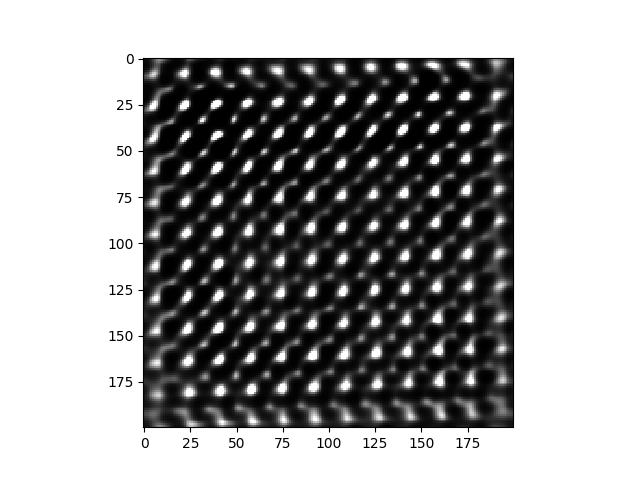

In [25]:
one_grain_indices = np.argmax(angles)
one_grain = middle_atoms # [one_grain_indices]
print(one_grain.shape)
one_grain_angle = np.max(one_grain[:, 2]%np.radians(60))


gamma = np.radians(layer.cell.angles()[2])
length = 22
plt.close('all')
plt.figure()
plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
#plt.scatter(one_grain[:, 0], one_grain[:, 1], c='blue', alpha = 0.2)

init = np.argmin(np.linalg.norm(blobs[:,:2]- [812, 199], axis=1))

#init = np.argmin(np.linalg.norm(blobs[:,:2]- [610, 552], axis=1))
init = 500
#plt.scatter(blobs[init][0], blobs[init][1], c='orange')
projection_tags = {'lattice_vector': {'a': np.array([np.cos(one_grain_angle)*length, np.sin(one_grain_angle)*length]),
                                      'b': np.array([np.cos(one_grain_angle+gamma)*length, np.sin(one_grain_angle+gamma)*length]) },
                   'allowed_variation': 5,
                   'distance_unit_cell':  length*1.04}
layer.info['projection'] = projection_tags
hop1, ideal = pyTEMlib.graph_tools.breadth_first_search2(blobs[:,:2], init, layer)
init = np.argmin(np.linalg.norm(blobs[:,:2]- [89, 989], axis=1))

hop2, ideal = pyTEMlib.graph_tools.breadth_first_search2(blobs[:,:2], init, layer)
plt.scatter(hop1[:,0], hop1[:,1], c='red', alpha = 0.3)
plt.scatter(hop2[:,0], hop2[:,1], c='blue', alpha = 0.3)


one_grain_angle